In [3]:
import glob
import pandas as pd
import numpy as np
import anndata as ad
import muon
import scanpy as sc
import scanpy.external as sce
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scanpy.external as sce
import pathlib
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 10,
    'font.family': "Arial",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 100
   }

mpl.rcParams.update(params)

sns.set_style("ticks")
sns.set_context(context='paper')
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
mpl.rc('savefig', dpi=300)
output_dir='../../figures/'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(format='pdf', transparent=True,)
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20) 
pd.set_option('display.width', 100)
%load_ext autoreload
%autoreload 2

run_name = "integrate_vdj"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%run _helper.py

In [5]:
adatas = []
subsample = False
for file in glob.glob("/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/*Bcells*h5ad"):
    print(file)
    # do the routine:
    # load data
    adata = sc.read_h5ad(file)
    # subsample based on being large amount of cells
    if subsample:
        if adata.shape[0] > 10000:
            sc.pp.subsample(adata, fraction=1)
    adatas.append(adata)
adata = ad.concat(adatas)

/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/BM_Bcells_Filtered.h5ad
/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/LN_Bcells_Filtered.h5ad
/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/SP_Bcells_Filtered.h5ad
/home/michaelswift/repos/tabula-bursa/analysis/notebooks/by_tissue_qc/outputs/tissue_objs/PB_Bcells_Filtered.h5ad


In [6]:
adata = reformat_adata_obs(adata)

In [10]:
df = pd.read_table("/home/michaelswift/repos/shared_data/tbd_share/vdj_integrated_with_flags.tsv.gz", index_col=0)
#df = df[df.gex_status == 'both available']
df = df.reset_index()

df['cb_suid'] = df['cb'] + "_" + df['sample_uid']

# there seem to be some dupliates
sns.displot(df['cb_suid'].value_counts())

# remove duplicates
df = df[~df['cb_suid'].duplicated()]
# merge data
obs_df = adata.obs
obs_df['cb'] = pd.Series(obs_df.index).str.split('-', expand = True)[0].values
obs_df['cb_suid'] = obs_df['cb'] + "_" + obs_df['sample_uid']
obs_df.set_index('cb_suid', inplace = True)

obs_df = pd.merge(obs_df, df, left_on='cb_suid', right_on='cb_suid', how = 'left', suffixes=[None, "_vdj"])

adata.obs = obs_df

adata.obs.index = adata.obs['cb_suid']

# create a donor_tissue column for lightweight batch correction
adata.obs['donor_tissue'] = adata.obs.donor.astype(str) + adata.obs.tissue.astype(str)

In [12]:
both_only = True            
if both_only:
    adata = adata[adata.obs[~adata.obs['gex_status'].isna()].index]
subsample = False
if subsample:
        if adata.shape[0] > 10000:
            sc.pp.subsample(adata, fraction=0.2)

In [13]:
adata = adata[adata.obs.gex_status == 'both available']

import scvi

scvi.model.SCVI.setup_anndata(adata, layer="umi_counts", batch_key="donor_tissue")

# reset X to umi counts and preprocess everyone similarly

## Because the Adata Interface is clunky and we'll be adding the other modalities soon i'm switching to mdata

In [14]:
subsample = True
if subsample:
        if adata.shape[0] > 10000:
            sc.pp.subsample(adata, fraction=0.5)

In [15]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

In [16]:
mdata = muon.MuData({"rna": adata.copy(), "log_norm_rna": adata.copy()}, axis=-1)
# Now rna is count-based and log_norm_rna is log-normalized
mdata.mod["rna"].X = mdata.mod["rna"].layers["umi_counts"]
del mdata.mod["rna"].raw
del mdata.mod["rna"].layers["umi_counts"]
del mdata.mod["log_norm_rna"].layers["umi_counts"]
mdata

MuData object with n_obs × n_vars = 53743 × 36601
  2 modalities
    rna:	53743 x 36601
      obs:	'cb_suid', 'sample_uid', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Unnamed: 0', 'donor', 'sample_type', 'sample_descriptor', 'tissue', 'sample_index', 'library_uid', 'lib_type', 'expected_cells_thousands', 'resequenced', 'leiden', 'predicted_labels', 'majority_voting', 'conf_score', 'global_leiden', 'over_clustering', 'b_lineage_leiden', 'possible_predicted_labels', 'predicted_label', 'cb', 'sample_uid_vdj', 'cb_vdj', 'locus', 'vdjc_info', 'vdj_sequence', 'c_call', 'n_umis', 'n_reads', 'stop_codon', 'vj_in_frame', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction', 'junction_length', 'junction_aa', 'junction_aa_length', 'v_score', 'd_score', 'j_score', 'v_identity', 'd_identity', 'j_identity', 'np1', 'np1_length', 'np2', 'np2_length', 'v_sequence', 'v_family', 'v_sequence_no_trunc', 'lineage_id', 'v_seq_id', 'v_db_call', 'v_pident', 'v_match_length', 'v_mismatch', 'v_gapopen', 'v_qstart', 'v_qend', 'v_sstart', 'v_send', 'v_evalue', 'v_mutations', 'sample_name', 'origin', 'donor_vdj', 'cell_id', 'source', 'contaminant_status', 'tissue_vdj', 'index', 'barcode', 'celltypist_coarse', 'n_genes_vdj', 'total_counts_vdj', 'total_counts_mt_vdj', 'PB_leiden', 'LN_leiden', 'BM_leiden', 'SP_leiden', 'bcell_subtype', 'multiplet_status', 'ambient_status', 'gex_status', 'vdj_sequence_in_ambient', 'donor_tissue'
      uns:	'log1p'
      obsm:	'X_pca', 'X_umap'
      layers:	'background_removed'
    log_norm_rna:	53743 x 36601
      obs:	'cb_suid', 'sample_uid', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Unnamed: 0', 'donor', 'sample_type', 'sample_descriptor', 'tissue', 'sample_index', 'library_uid', 'lib_type', 'expected_cells_thousands', 'resequenced', 'leiden', 'predicted_labels', 'majority_voting', 'conf_score', 'global_leiden', 'over_clustering', 'b_lineage_leiden', 'possible_predicted_labels', 'predicted_label', 'cb', 'sample_uid_vdj', 'cb_vdj', 'locus', 'vdjc_info', 'vdj_sequence', 'c_call', 'n_umis', 'n_reads', 'stop_codon', 'vj_in_frame', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction', 'junction_length', 'junction_aa', 'junction_aa_length', 'v_score', 'd_score', 'j_score', 'v_identity', 'd_identity', 'j_identity', 'np1', 'np1_length', 'np2', 'np2_length', 'v_sequence', 'v_family', 'v_sequence_no_trunc', 'lineage_id', 'v_seq_id', 'v_db_call', 'v_pident', 'v_match_length', 'v_mismatch', 'v_gapopen', 'v_qstart', 'v_qend', 'v_sstart', 'v_send', 'v_evalue', 'v_mutations', 'sample_name', 'origin', 'donor_vdj', 'cell_id', 'source', 'contaminant_status', 'tissue_vdj', 'index', 'barcode', 'celltypist_coarse', 'n_genes_vdj', 'total_count

In [17]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
pearson_residuals = False
if pearson_residuals:
    adata = adata[:,~adata.var.index.str.contains("IGH|IGL|IGK|AC|AL")].copy()
    sc.experimental.pp.recipe_pearson_residuals(adata, batch_key='tissue')
else:
    sc.pp.highly_variable_genes(adata, batch_key='donor_tissue')
    adata = adata[:,~adata.var.index.str.contains("IGL|IGK|AC|AL|HSP|DNAJB|FOS|JUN|JUNB|RPS26|XIST")].copy()
    adata.raw = adata

### light-weight batch correction by choosing HVGs from different tissues

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scan

In [18]:
sc.pp.scale(adata, max_value=5)

In [19]:
sc.pp.pca(adata)

In [25]:
sc.pl.pca_overview(adata, color = 'tissue', save = "{}_{}".format(run_name, "overview")
sc.pl.pca_scatter(adata, color = 'FNDC3B', projection='3d', save=run_name)

SyntaxError: invalid syntax (<ipython-input-25-3e54c9c2d487>, line 1)

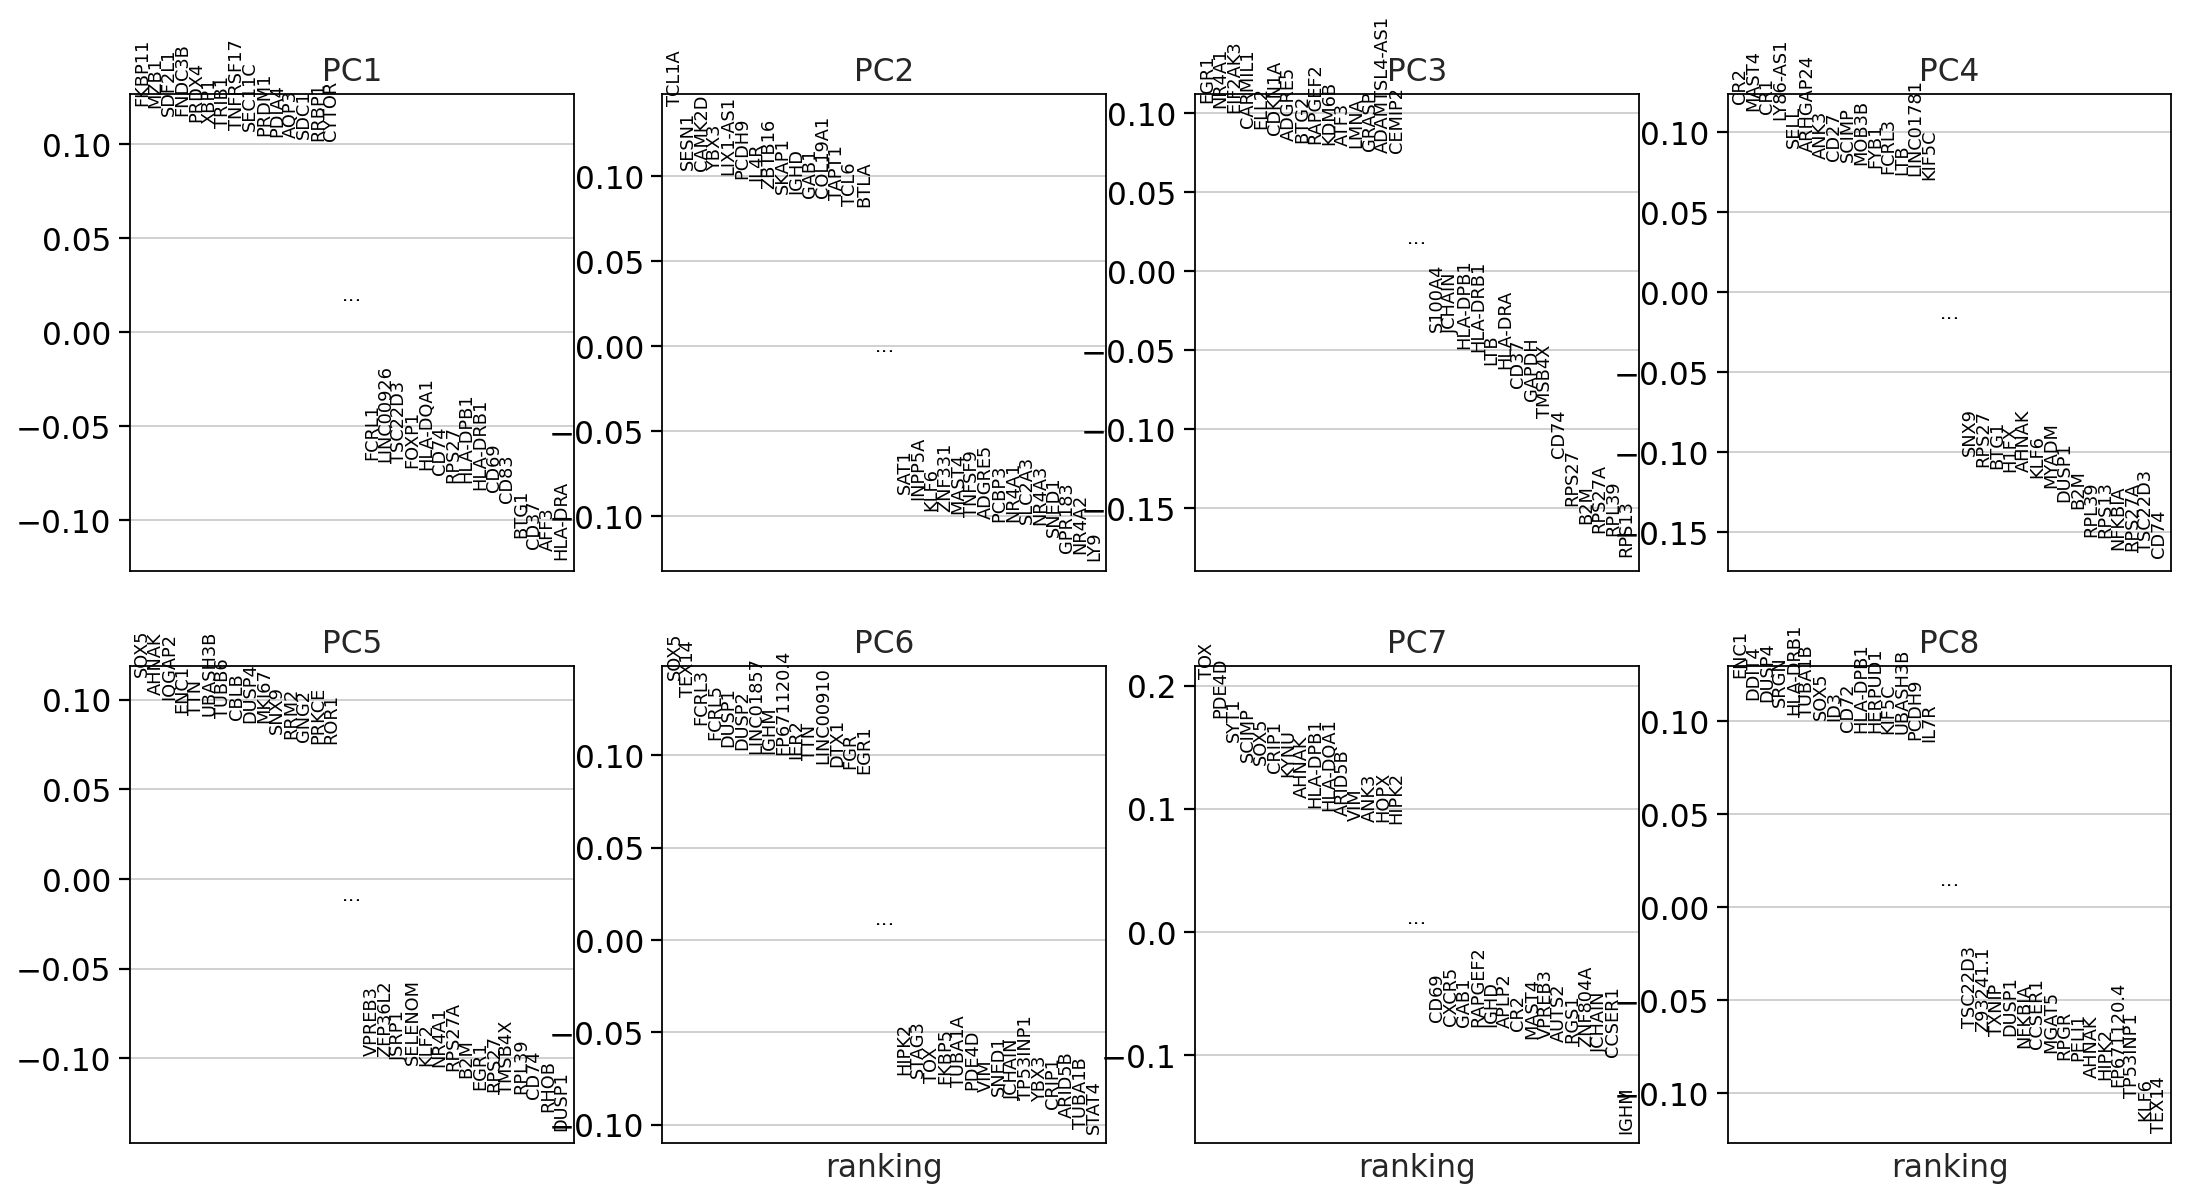

In [21]:
sc.pl.pca_loadings(adata, components='1,2,3,4,5,6,7,8', save=run_name)

In [22]:
adata = cluster(adata, batch_correct=False, batch_key="donor", pca = False)

drawing neighbor graph
UMAP-ing
leiden-ing


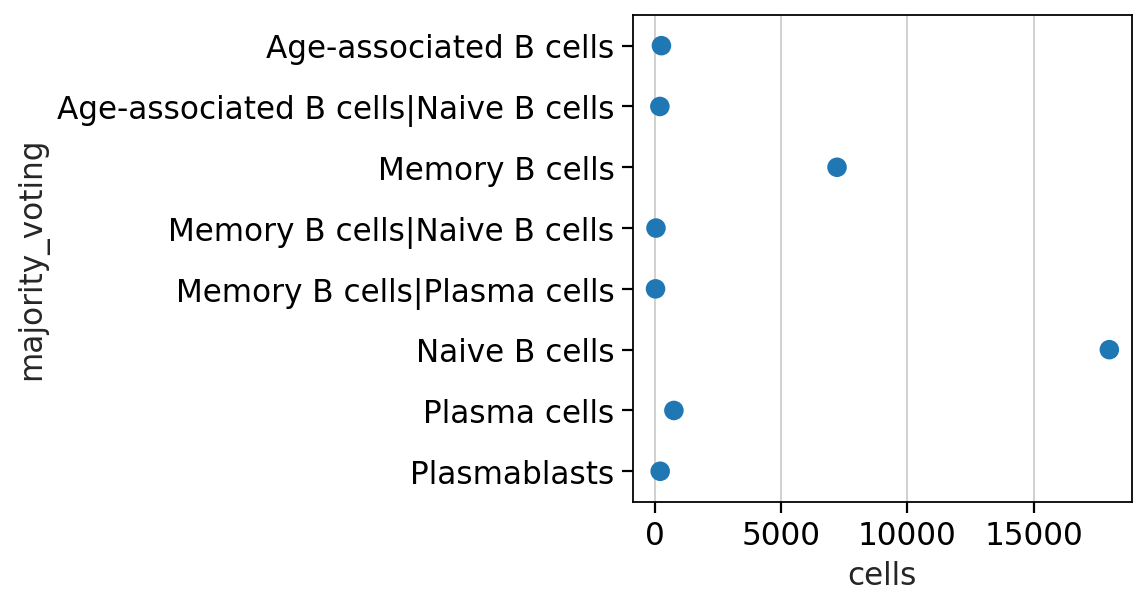

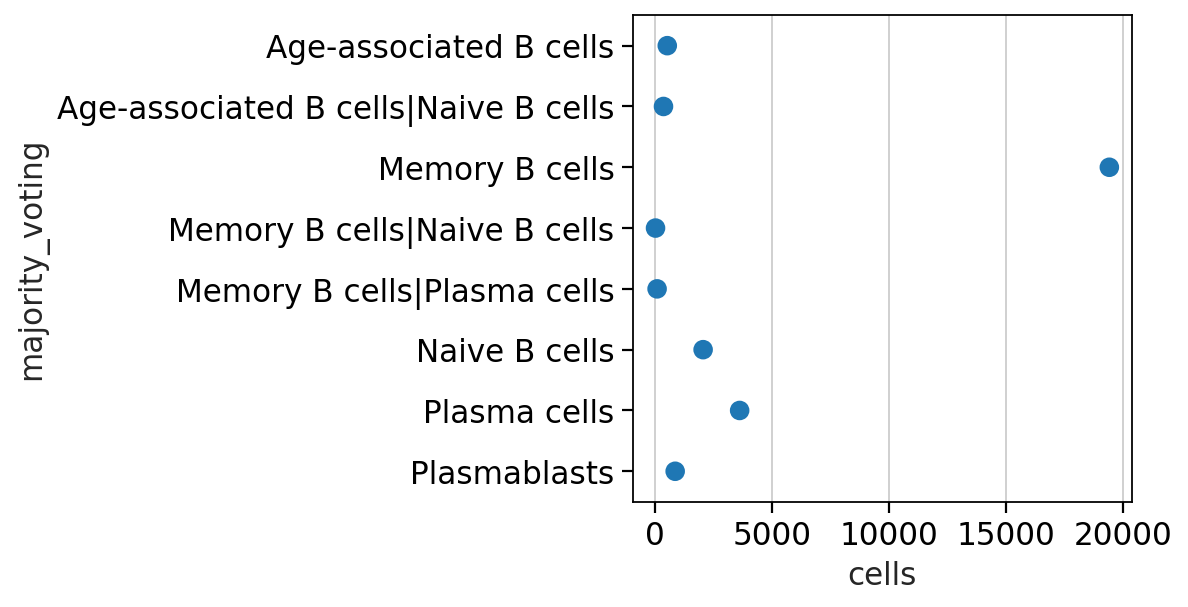

In [23]:
data = pd.DataFrame(adata.obs[adata.obs.v_identity.isna()].majority_voting.value_counts()).reset_index()
data.columns = ['majority_voting', 'cells']
fig, ax = plt.subplots(1,1)
sns.pointplot(data, x = 'cells', y = 'majority_voting', join = False)
save_figure(fig, "na_cells_abundance")

data = pd.DataFrame(adata.obs[~adata.obs.v_identity.isna()].majority_voting.value_counts()).reset_index()
data.columns = ['majority_voting', 'cells']
fig, ax = plt.subplots(1,1)
sns.pointplot(data, x = 'cells', y = 'majority_voting', join = False)
save_figure(fig, "notna_cells_abundance")

In [30]:
adata.obs.v_identity = adata.obs.v_identity.fillna(100)

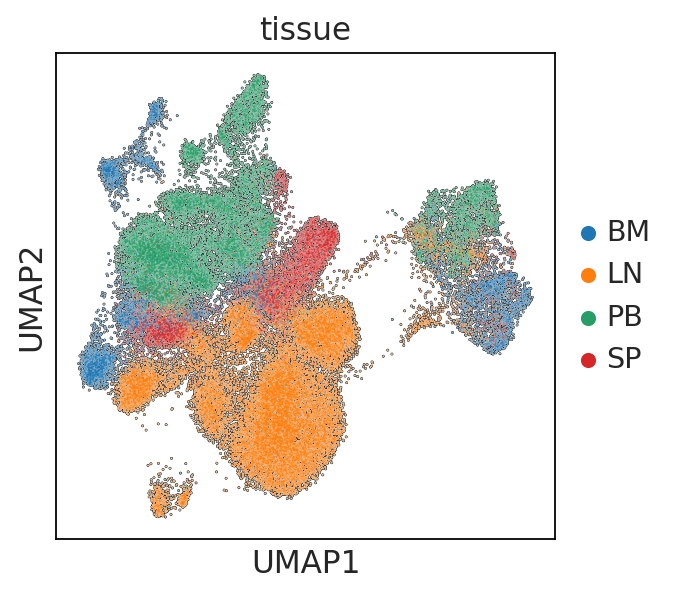

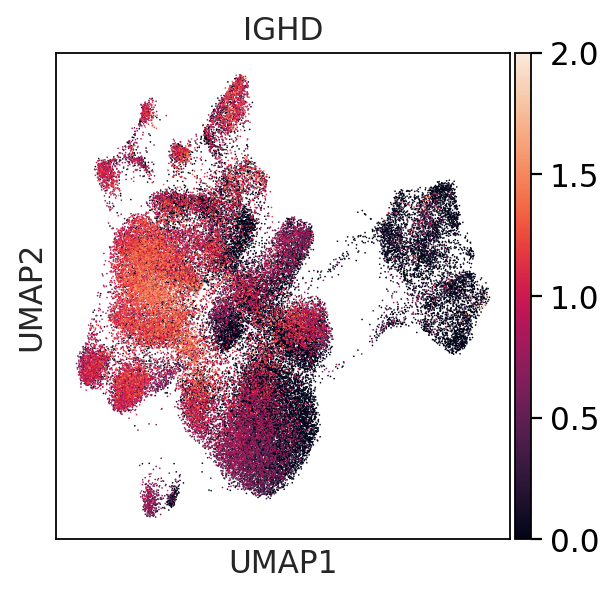

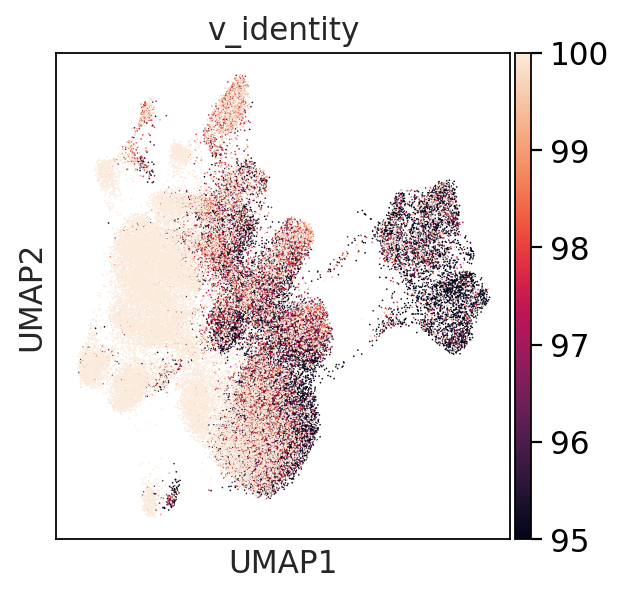

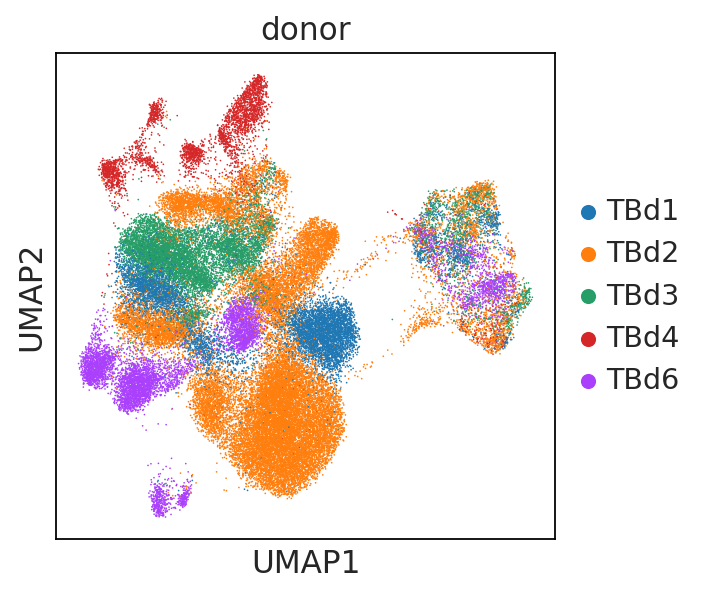

In [31]:
sc.pl.umap(adata, color = 'tissue', alpha = 0.5, add_outline=True)
sc.pl.umap(adata, color = 'IGHD', alpha = 1, vmax = 2)
sc.pl.umap(adata[~adata.obs.v_identity.isna()], color = 'v_identity', vmax = 100, vmin = 95)
sc.pl.umap(adata, color = 'donor', alpha = 1)

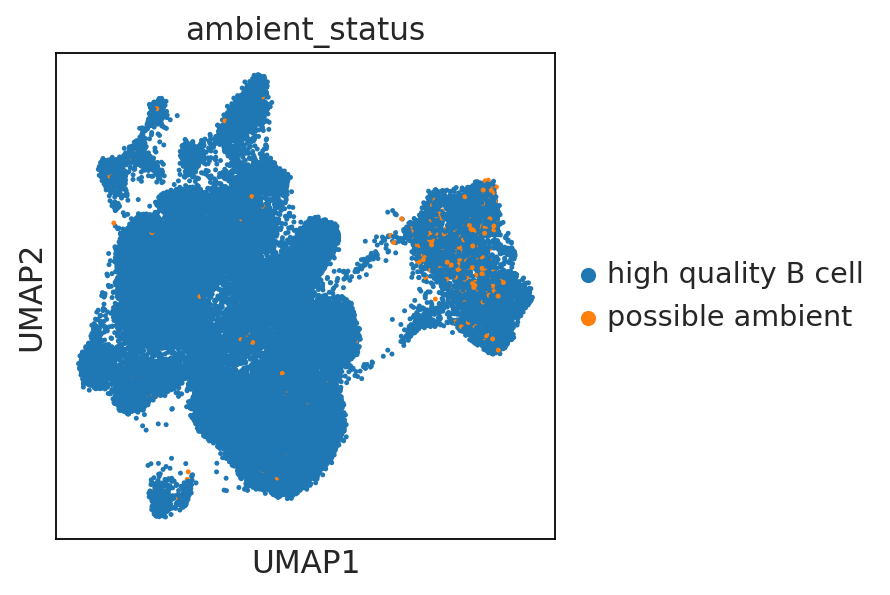

In [69]:
sc.pl.umap(adata, color = 'ambient_status', alpha = 1, size = 20)

## Re Annotate the Cells

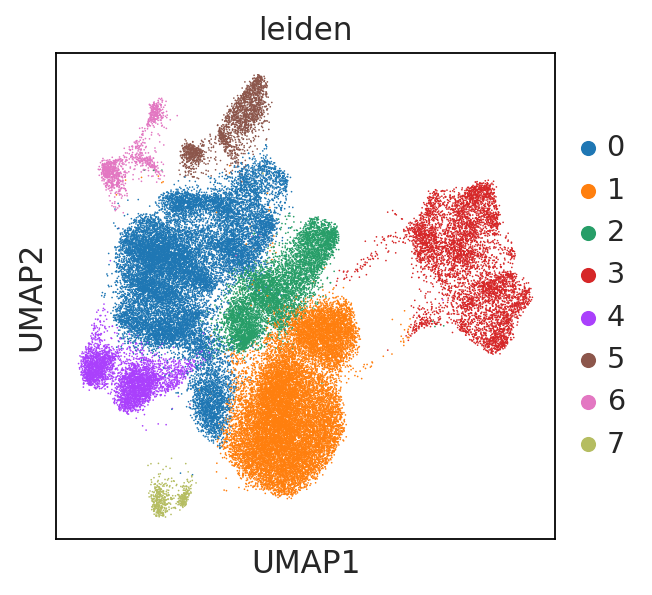

In [35]:
sc.pl.umap(adata, color = 'leiden')

In [36]:
sc.tl.rank_genes_groups(adata, groupby='leiden')

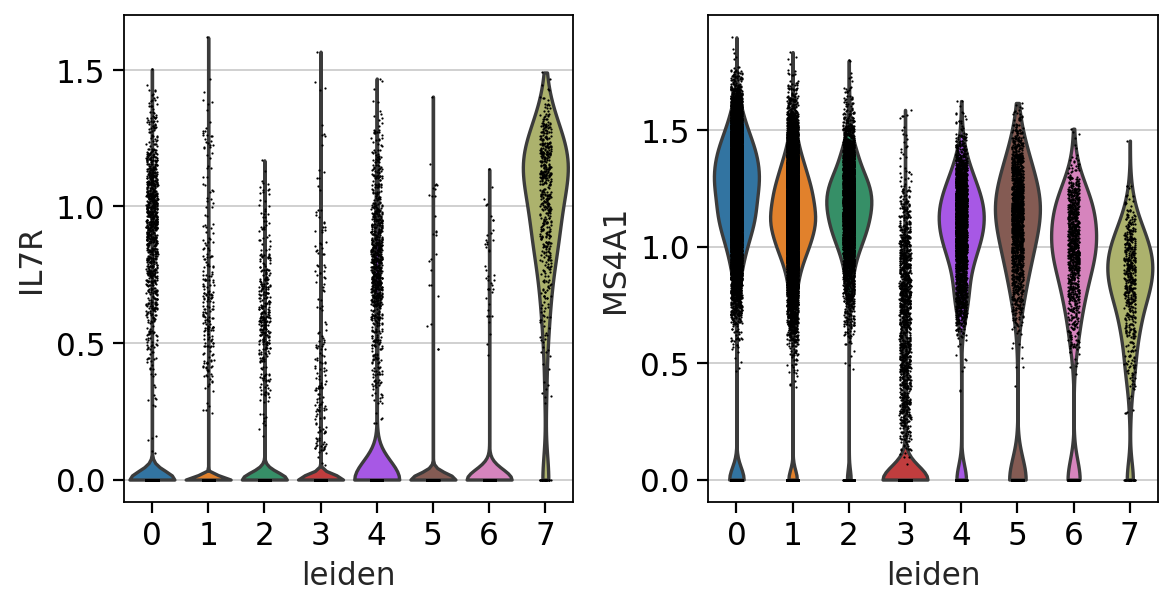

In [43]:
sc.pl.violin(adata, keys = ['IL7R', 'MS4A1'], groupby='leiden')

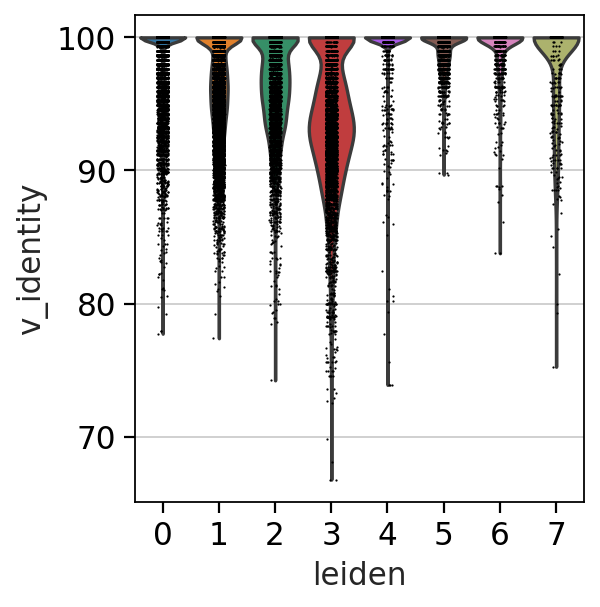

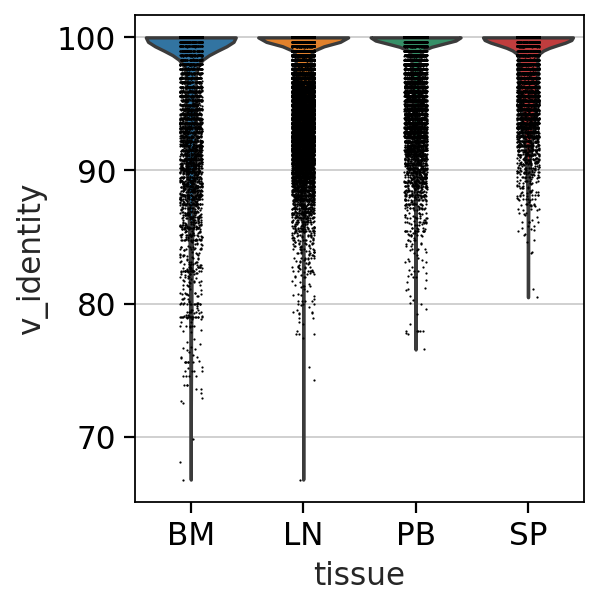

In [46]:
sc.pl.violin(adata, keys = 'v_identity', groupby='leiden')
sc.pl.violin(adata, keys = 'v_identity', groupby='tissue')

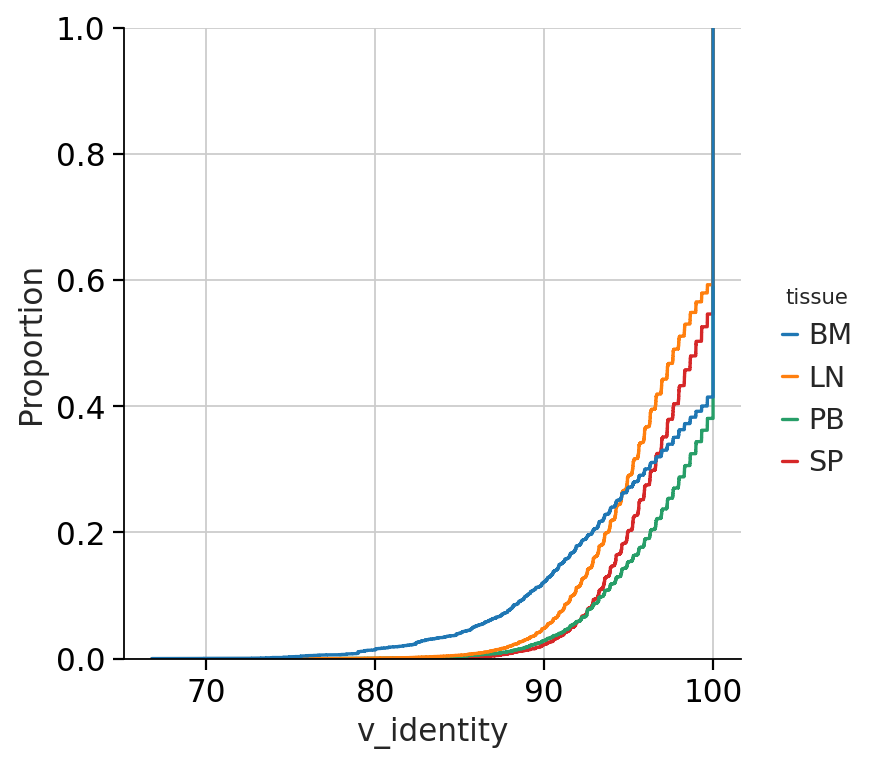

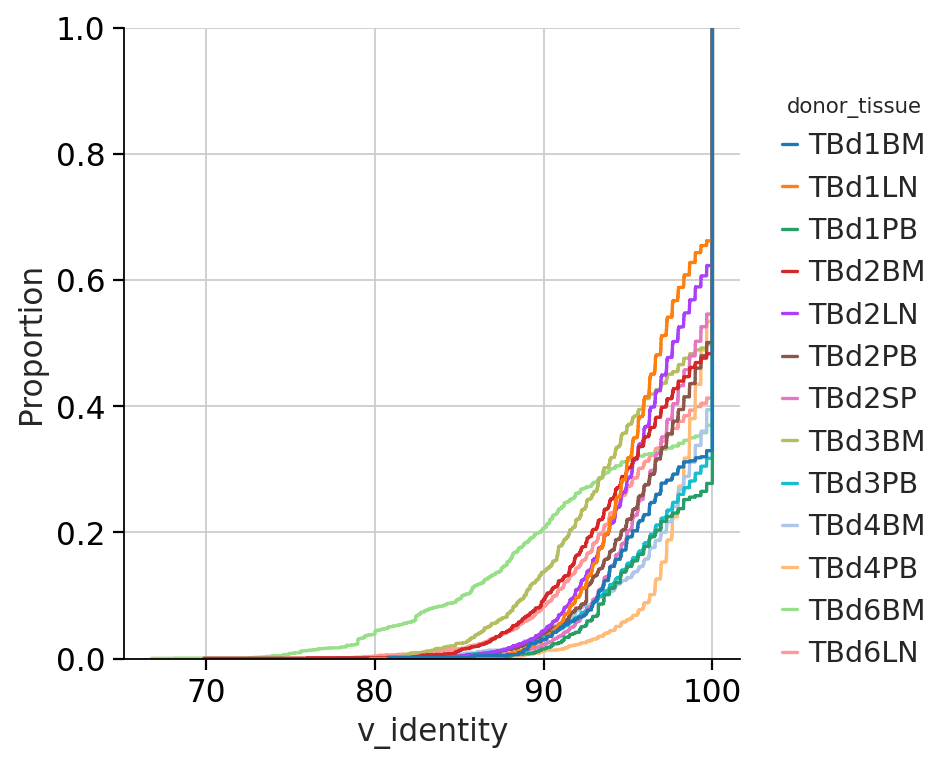

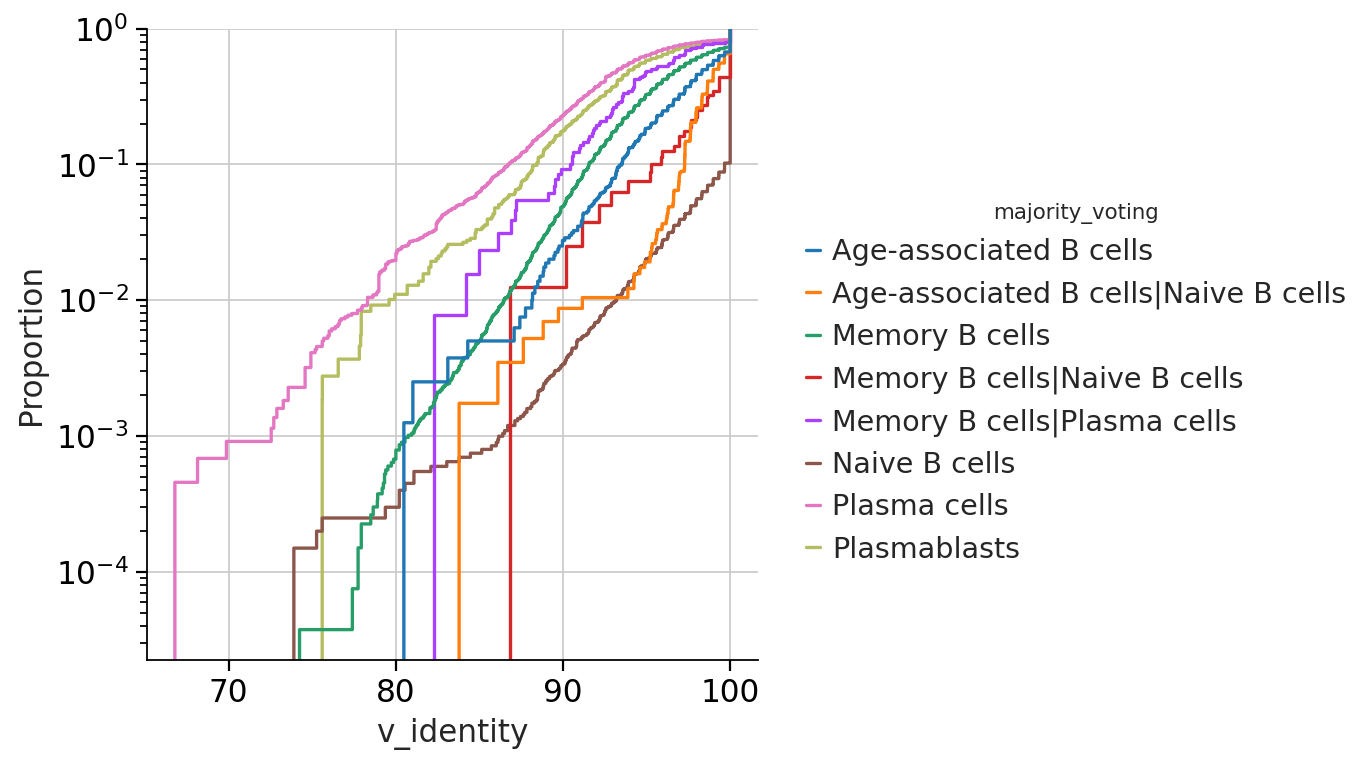

In [55]:
sns.displot(adata.obs, x = 'v_identity', kind='ecdf', hue = 'tissue')
sns.displot(adata.obs, x = 'v_identity', kind='ecdf', hue = 'donor_tissue')
sns.displot(adata.obs, x = 'v_identity', kind='ecdf', hue = 'majority_voting')
plt.yscale('log')

In [62]:
adata.obs.groupby('sample_type').tissue.value_counts()

sample_type    
fresh        LN     4618
             BM     3188
             PB     2421
             SP        0
frozen       LN    20723
             PB    13575
             SP     5775
             BM     3443
Name: tissue, dtype: int64

PB
LN
BM
SP


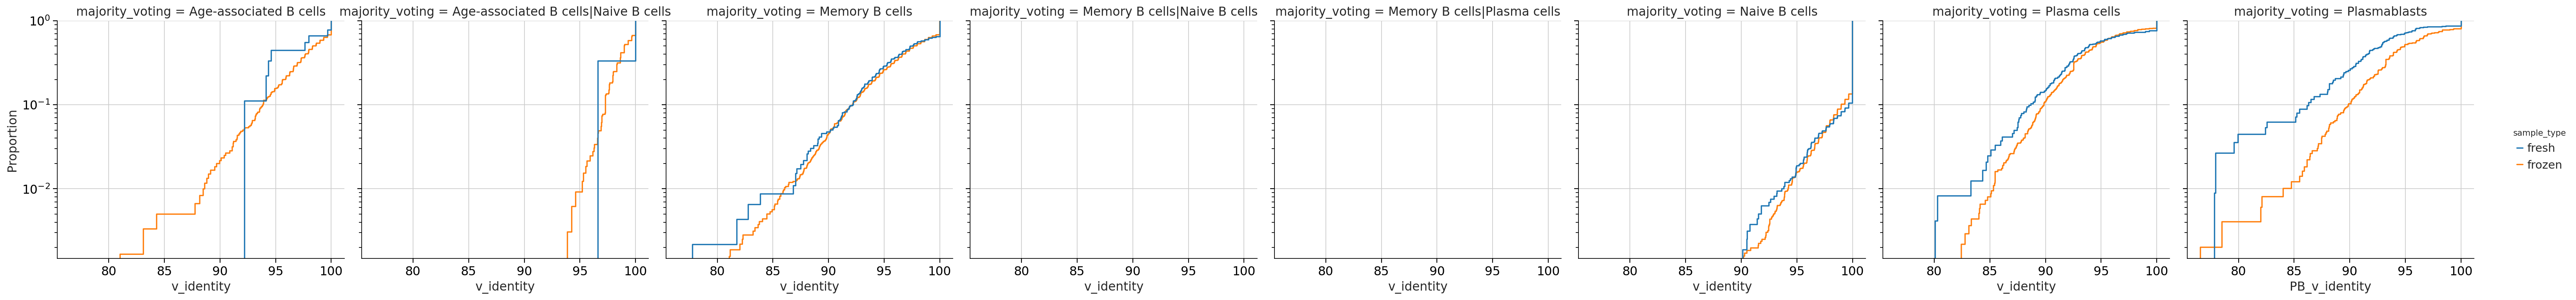

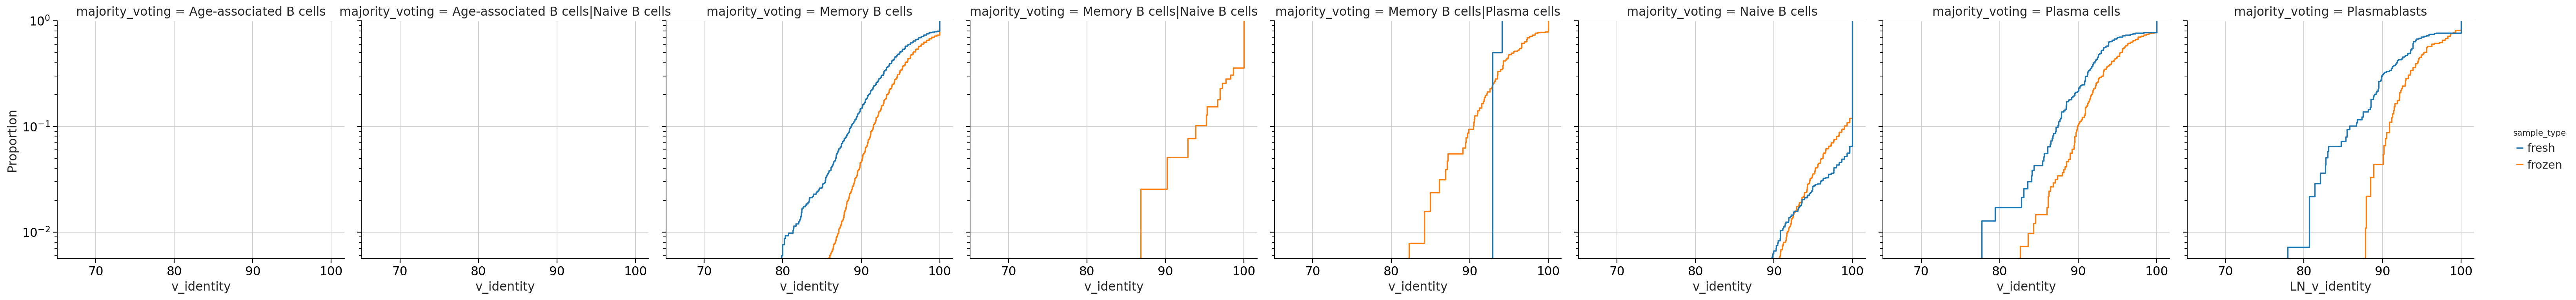

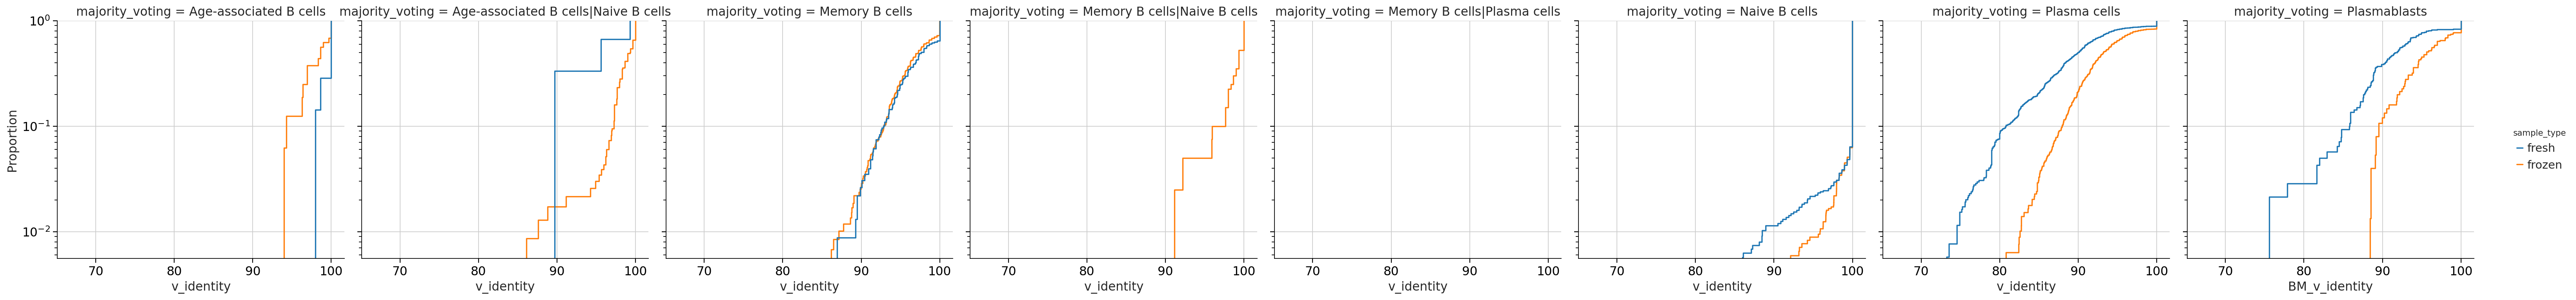

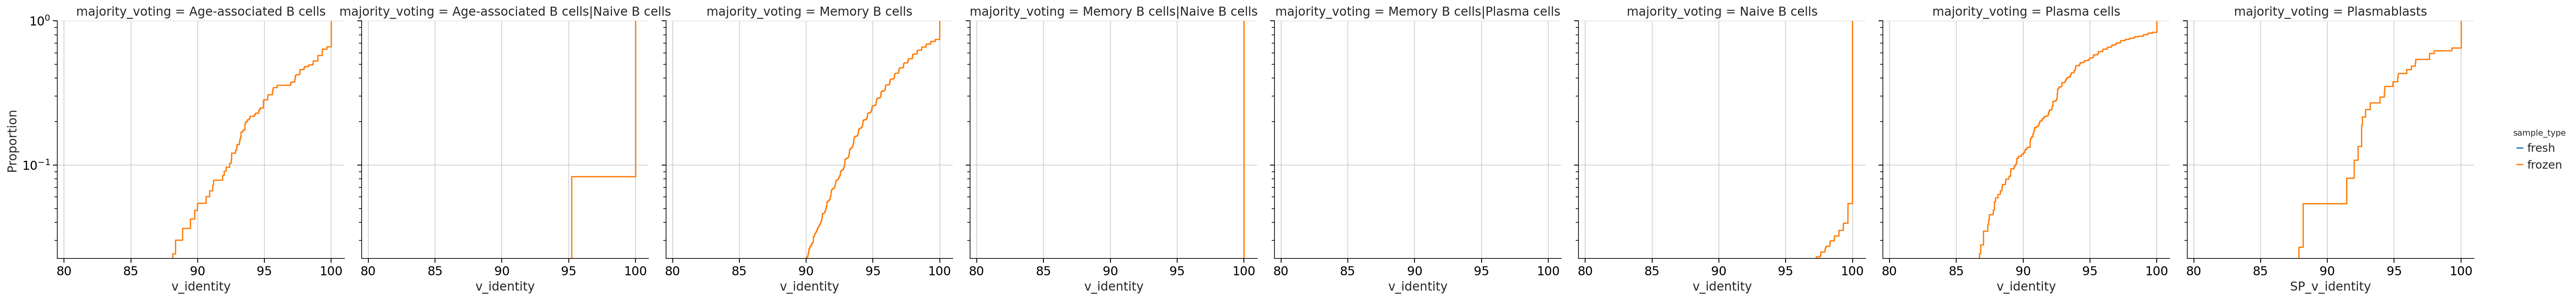

In [63]:
for i in adata.obs.tissue.unique():
    print(i)
    data = adata.obs[adata.obs.tissue == i]
    sns.displot(data, x = 'v_identity', kind='ecdf', col='majority_voting', hue = 'sample_type')
    plt.yscale('log')
    plt.xlabel('{}_v_identity'.format(i))

TBd3
TBd2
TBd6
TBd1
TBd4


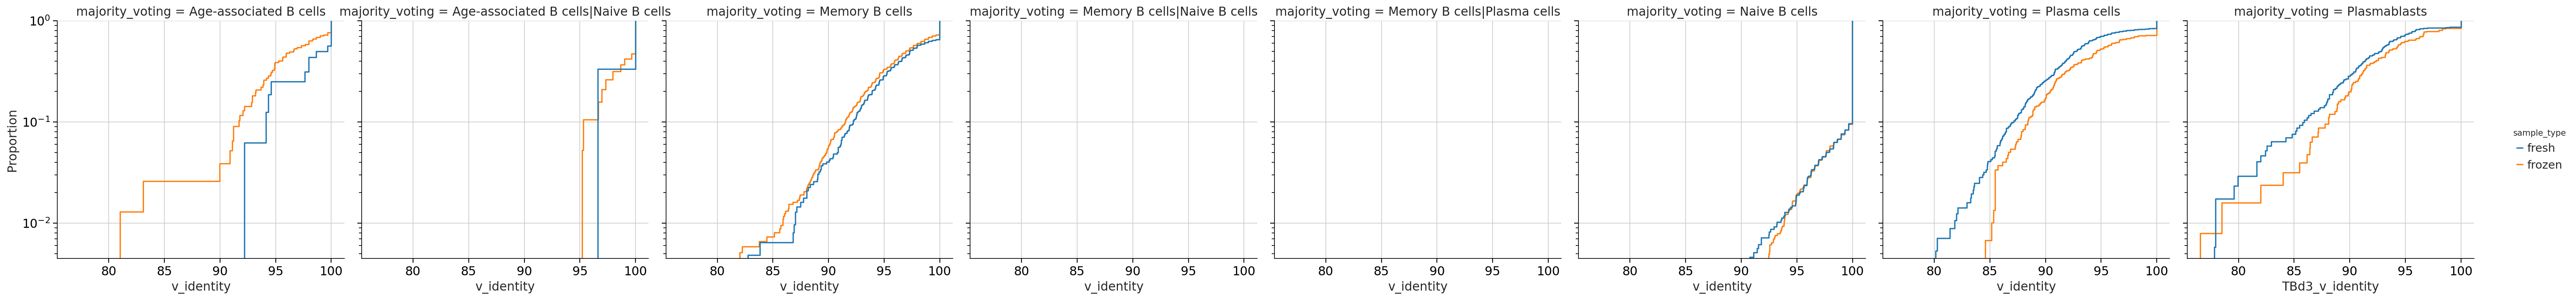

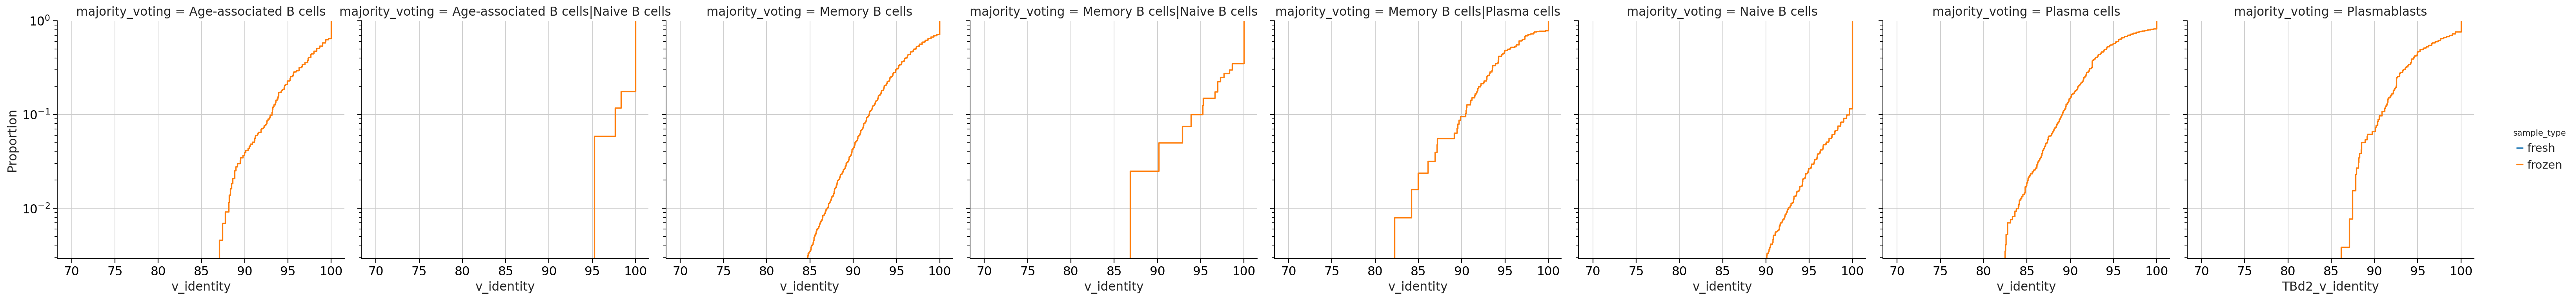

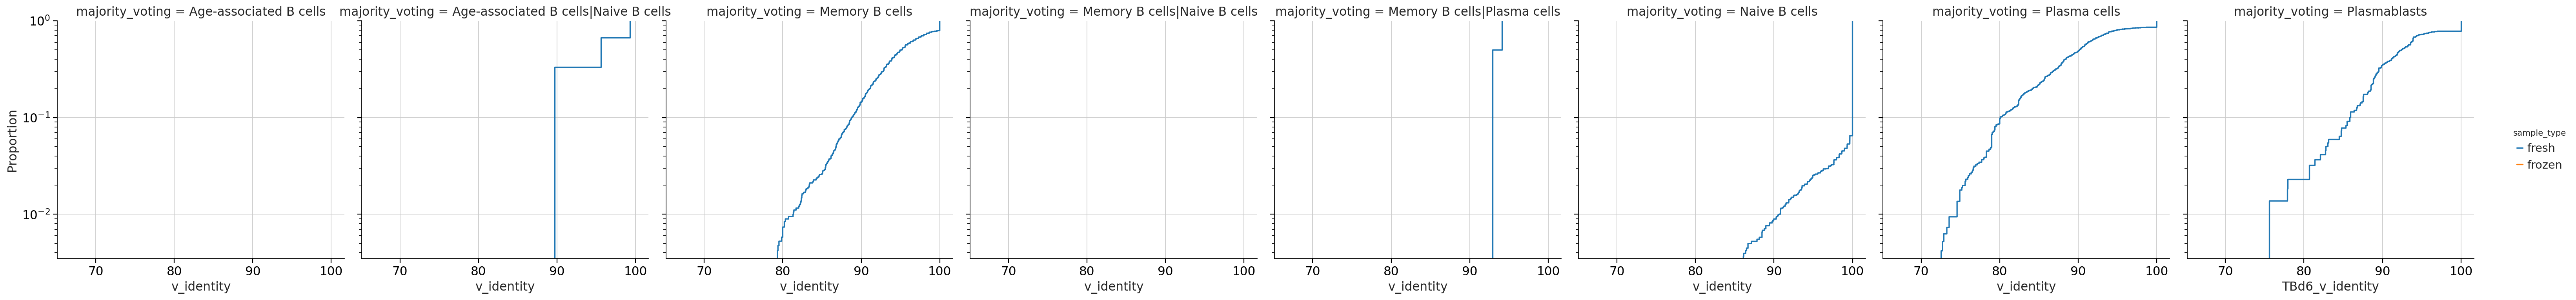

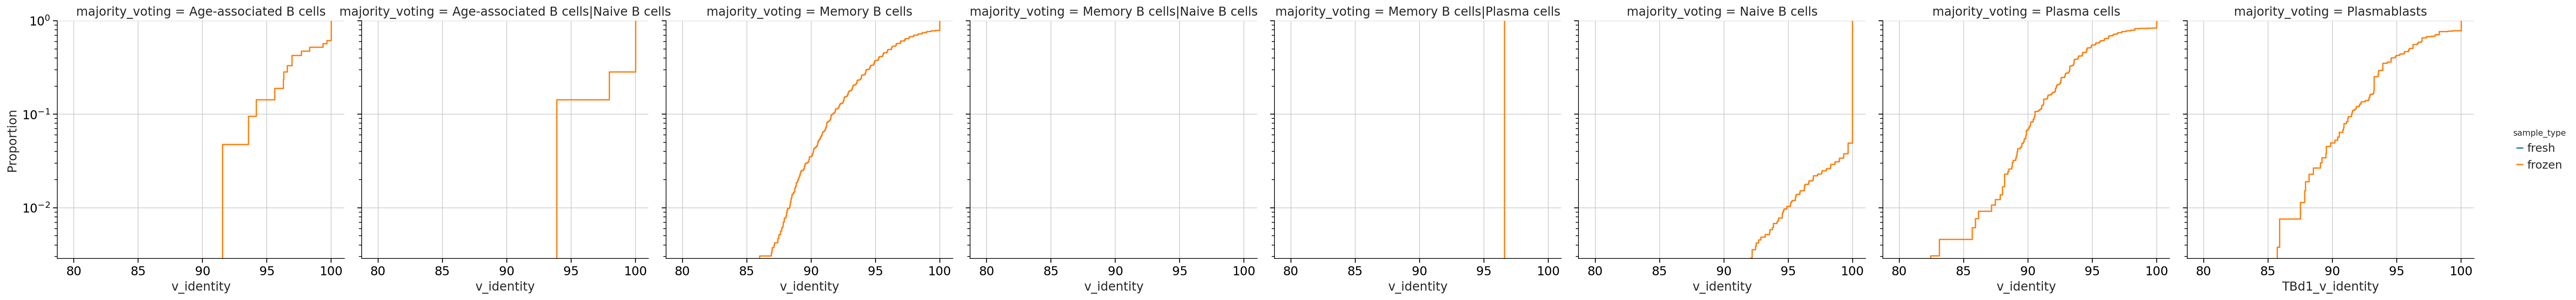

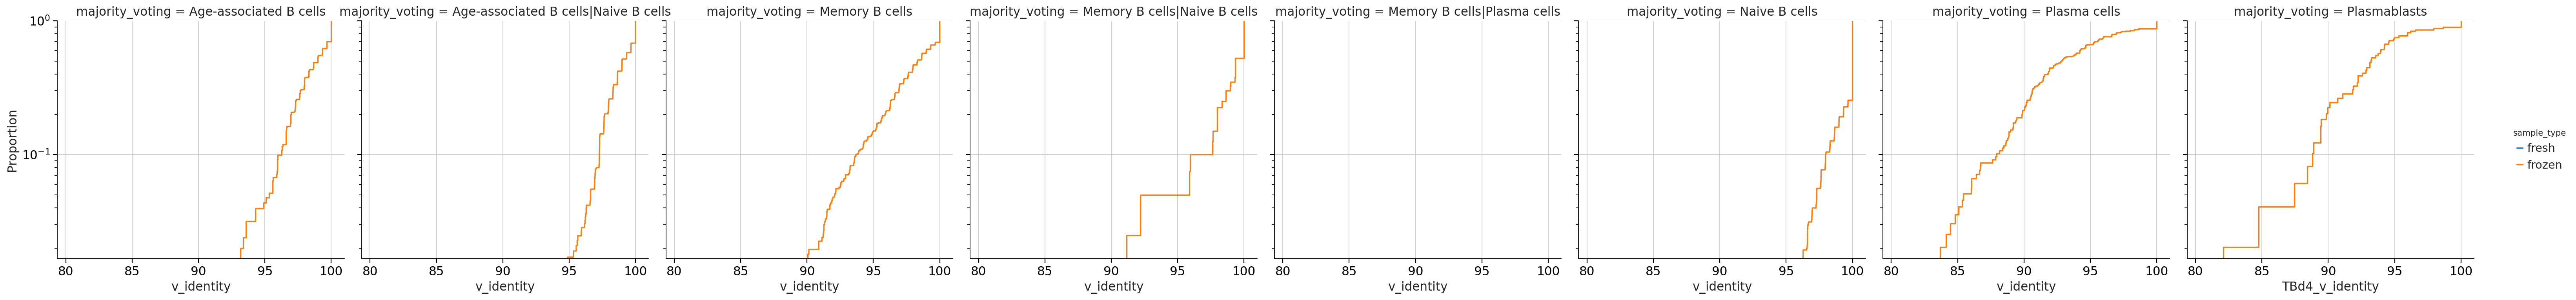

In [65]:
for i in adata.obs.donor.unique():
    print(i)
    data = adata.obs[adata.obs.donor == i]
    sns.displot(data, x = 'v_identity', kind='ecdf', col='majority_voting', hue = 'sample_type')
    plt.yscale('log')
    plt.xlabel('{}_v_identity'.format(i))

AnnData object with n_obs × n_vars = 53743 × 24155
    obs: 'cb_suid', 'sample_uid', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Unnamed: 0', 'donor', 'sample_type', 'sample_descriptor', 'tissue', 'sample_index', 'library_uid', 'lib_type', 'expected_cells_thousands', 'resequenced', 'leiden', 'predicted_labels', 'majority_voting', 'conf_score', 'global_leiden', 'over_clustering', 'b_lineage_leiden', 'possible_predicted_labels', 'predicted_label', 'cb', 'sample_uid_vdj', 'cb_vdj', 'locus', 'vdjc_info', 'vdj_sequence', 'c_call', 'n_umis', 'n_reads', 'stop_codon', 'vj_in_frame', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 